In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import numpy as np
import pandas as pd
import torch

from hparams import create_hparams
from model import SpeakerEncoder
from audio import init_stft, mel_spectrogram

import os
import warnings
warnings.filterwarnings("ignore")


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



/Users/olehmatsuk/opt/anaconda3/envs/taco/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [4]:
pd.read_csv('/Users/olehmatsuk/Thesis/data_files/vctk.csv').shape

(44085, 5)

In [2]:
def get_mel_fragment(fragment, data_dir):
    return mel_spectrogram(os.path.join(data_dir, fragment['audio']), stft)[:, fragment['from']:fragment['to']] \
        .transpose(0, 1) # FxM

def get_embeddings(model, fragments, data_dir):
    mels = []
    for _, fragment in fragments.iterrows():
        mel = get_mel_fragment(fragment, data_dir)
        mels.append(mel)
    mels = torch.stack(mels)
    return model(mels).detach()

In [3]:
def load_model(checkpoint_path):
    model = SpeakerEncoder(hparams)
    if checkpoint_path is not None: 
        model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu'))['state_dict'])
    return model

In [4]:
import IPython

def play_audio(audio, data_dir):
    return IPython.display.Audio(os.path.join(data_dir, audio), autoplay=True)

In [5]:
def speaker_sample(fragments, speaker):
    return fragments.loc[fragments['speaker'] == speaker].sample(1).iloc[0]

In [6]:
from sklearn.decomposition import PCA
import seaborn as sns
sns.set(rc={'figure.figsize':(12, 12)})

def pca_plot(embeddings, labels, genders=None):
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings.numpy())

    for label in np.sort(np.unique(labels)):
        label_index = labels == label
        marker = None if genders is None else ('x' if genders[label] else '.')
        plt.scatter(embeddings_2d[label_index, 0], embeddings_2d[label_index, 1], label=label, marker=marker)
    plt.legend()

In [7]:
hparams = create_hparams()
stft = init_stft(hparams)

### Load data

In [8]:
test_common_voice = pd.read_csv('/Users/olehmatsuk/Thesis/data_files/common_voice_fragments_test.csv')
test_common_voice.head()

,mel,speaker,from,to,audio
0,common_voice_et_18308560.npy,2546b52782d46a01500bff6bebb2527ce2a1ef0026bcfa...,420,490,common_voice_et_18308560.mp3
1,common_voice_et_18146487.npy,a7c34b9164e1d6f5635846fd9e6fb261e978376e349414...,140,210,common_voice_et_18146487.mp3
2,common_voice_et_18318841.npy,58c5bd198e4625248c9ce13a644ad531ee7557b26cd73f...,70,140,common_voice_et_18318841.mp3
3,common_voice_et_18139879.npy,fce9a476ff72372a2011f3f7dd474d7b98b718b34eae3a...,490,560,common_voice_et_18139879.mp3
4,common_voice_et_18279760.npy,44c80063991b3d8465541af15c082b89b8e1a2e3b37f0d...,0,70,common_voice_et_18279760.mp3


In [9]:
konekorpus_speakers = ["Meelis_Kompus", "Tarmo_Maiberg", "Birgit_Itse", "Vallo_Kelmsaar", "Indrek_Kiisler",
                       "Tõnu_Karjatse", "Kai_Vare", "Katarina", "Kristo", "Robert", "Stella"]

test_konekorpus = pd.read_csv('/Users/olehmatsuk/Thesis/data_files/konekorpus_fragments_test.csv')
test_konekorpus['speaker'] = test_konekorpus['speaker'].apply(lambda s: konekorpus_speakers[s])
test_konekorpus.head()

,mel,speaker,from,to,audio
0,Stella_0001_art_213_lause_3.npy,Stella,840,910,Stella/0001_art_213_lause_3.wav
1,Katarina_0001_art_1235_lause_43.npy,Katarina,350,420,Katarina/0001_art_1235_lause_43.wav
2,Stella_0001_art_314_lause_15.npy,Stella,210,280,Stella/0001_art_314_lause_15.wav
3,Robert_0001_art_399_lause_3.npy,Robert,420,490,Robert/0001_art_399_lause_3.wav
4,Kristo_0001_art_204_lause_2.npy,Kristo,140,210,Kristo/0001_art_204_lause_2.wav


In [10]:
test_vctk = pd.read_csv('/Users/olehmatsuk/Thesis/data_files/vctk_fragments_test.csv')
test_vctk.head()

,mel,speaker,from,to,audio
0,p267_071.npy,p267,70,140,wav48/p267/p267_071.wav
1,p292_076.npy,p292,210,280,wav48/p292/p292_076.wav
2,p374_258.npy,p374,0,70,wav48/p374/p374_258.wav
3,p270_141.npy,p270,0,70,wav48/p270/p270_141.wav
4,p326_133.npy,p326,210,280,wav48/p326/p326_133.wav


In [11]:
test_common_voice.shape, test_konekorpus.shape, test_vctk.shape

((12861, 5), (100364, 5), (52121, 5))

In [12]:
common_voice_dir = '/Users/olehmatsuk/Thesis/data/common_voice'
konekorpus_dir = '/Users/olehmatsuk/Thesis/data/konekorpus'
vctk_dir = '/Users/olehmatsuk/Thesis/data/vctk'

In [13]:
konekorpus_speakers_genders = {"Meelis_Kompus": 1, 
                               "Tarmo_Maiberg": 1, 
                               "Birgit_Itse": 0, 
                               "Vallo_Kelmsaar": 1, 
                               "Indrek_Kiisler": 1, 
                               "Tõnu_Karjatse": 1, 
                               "Kai_Vare": 0, 
                               "Katarina": 0,
                               "Kristo": 1, 
                               "Robert": 1, 
                               "Stella": 0}

In [14]:
vctk_speaker_info = pd.read_csv(os.path.join(vctk_dir, 'speaker-info.txt'), delimiter='\s*', header=None, skiprows=1)
vctk_speakers_genders = {f'p{row[0]}': 1 if row[2] == 'M' else 0
                         for _, row in vctk_speaker_info.iterrows()}

### Prepare test data

In [15]:
test_konekorpus_sample = []
for speaker in test_konekorpus['speaker'].unique():
    test_konekorpus_sample.append(test_konekorpus.loc[test_konekorpus['speaker'] == speaker].sample(30))
test_konekorpus_sample = pd.concat(test_konekorpus_sample)
test_konekorpus_sample.head()

,mel,speaker,from,to,audio
69550,Stella_0001_art_7_lause_7.npy,Stella,0,70,Stella/0001_art_7_lause_7.wav
89939,Stella_0001_art_66_lause_8.npy,Stella,560,630,Stella/0001_art_66_lause_8.wav
76156,Stella_0001_art_295_lause_8.npy,Stella,0,70,Stella/0001_art_295_lause_8.wav
23824,Stella_0001_art_191_lause_4.npy,Stella,770,840,Stella/0001_art_191_lause_4.wav
59570,Stella_0001_art_176_lause_8.npy,Stella,140,210,Stella/0001_art_176_lause_8.wav


In [16]:
test_vctk_sample = []
for speaker in np.random.choice(test_vctk['speaker'].unique(), size=15, replace=False):
    test_vctk_sample.append(test_vctk.loc[test_vctk['speaker'] == speaker].sample(50))
test_vctk_sample = pd.concat(test_vctk_sample)
test_vctk_sample.head()

,mel,speaker,from,to,audio
9900,p360_114.npy,p360,0,70,wav48/p360/p360_114.wav
179,p360_128.npy,p360,70,140,wav48/p360/p360_128.wav
40984,p360_047.npy,p360,0,70,wav48/p360/p360_047.wav
43171,p360_002.npy,p360,210,280,wav48/p360/p360_002.wav
30934,p360_178.npy,p360,70,140,wav48/p360/p360_178.wav


In [17]:
test_konekorpus_sample.shape, test_vctk_sample.shape

((330, 5), (750, 5))

### Load models

In [19]:
checkpoint_path = '/Users/olehmatsuk/Thesis/runs/speaker_c_Jun23_22_42_54/checkpoint_45000'
model = load_model(checkpoint_path)

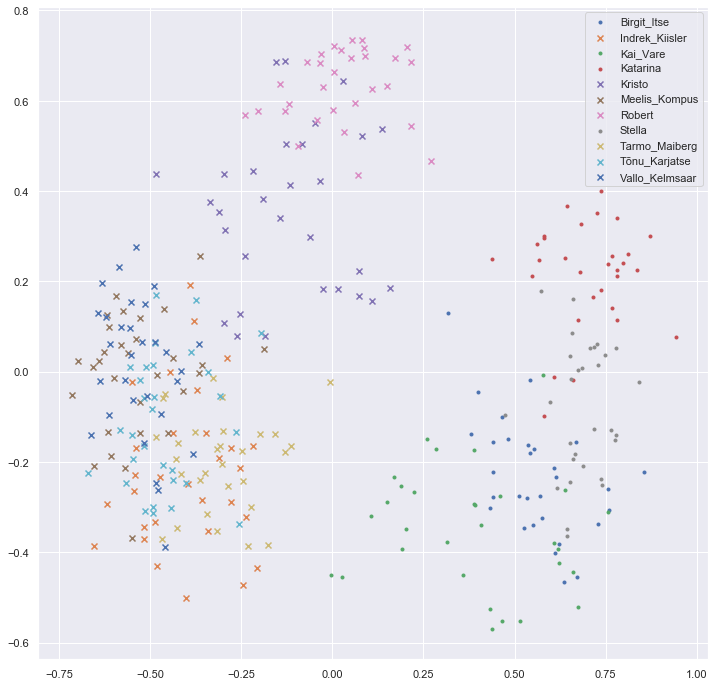

In [20]:
embeddings_konekorpus = get_embeddings(model, test_konekorpus_sample, konekorpus_dir)
pca_plot(embeddings_konekorpus, test_konekorpus_sample['speaker'], konekorpus_speakers_genders)

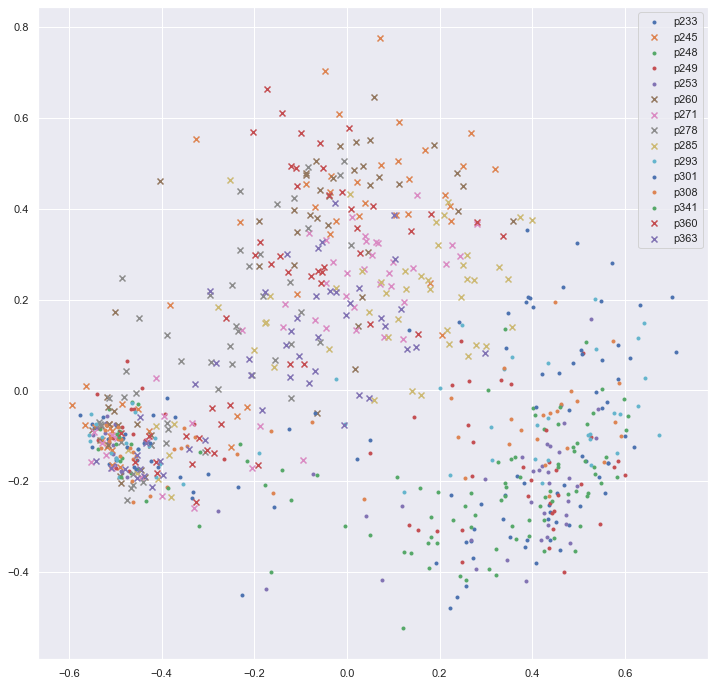

In [25]:
embeddings_vctk = get_embeddings(model, test_vctk_sample, vctk_dir)
pca_plot(embeddings_vctk, test_vctk_sample['speaker'], vctk_speakers_genders)

In [44]:
sample = speaker_sample(test_konekorpus_sample, 'Robert')
play_audio(sample['audio'], konekorpus_dir)

In [ ]:
'''
mel =  mel_spectrogram(os.path.join(data_dir, row['origin']), stft).transpose(0, 1).unsqueeze(0)
fragments = mel.unfold(1, 36, 18).transpose(2, 3)[0]
speaker_embedding = model.inference(fragments, [fragments.size(0)])
speaker_embeddings.append(speaker_embedding)
'''